- Import the basic libraries

In [1]:
import cv2 # Computer image
import imgaug as ia
import matplotlib.pyplot as plt
import numpy as np
import os, glob # Read the path file correctly
import pandas as pd
import tensorflow as tf
import zipfile

from imgaug import augmenters as iaa
from pathlib import Path
from skimage.io import imread, imsave
from skimage.transform import resize
from tensorflow import keras
from keras.models import Model
from keras import layers as L
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import RMSprop
from keras.applications import vgg16
from keras.applications.vgg16 import VGG16

%matplotlib inline

In [2]:
# Add the image data to colab

# from google.colab import drive
# drive.mount('path', force_remount = True)

In [3]:
# Linux code to unzip in colab

# !unzip r"C:\Users\younu\Desktop\My Py Scripts\Git Repos\17_Tomato Leaf Deficiency\tomato_leaf_images.zip"

In [4]:
path = r"C:\Users\younu\Desktop\My Py Scripts\Git Repos\17_Tomato Leaf Deficiency\tomato_leaf_images.zip"

zip_obect=zipfile.ZipFile(file=path,mode='r')
zip_obect.extractall('./')
zip_obect.close

<bound method ZipFile.close of <zipfile.ZipFile filename='C:\\Users\\younu\\Desktop\\My Py Scripts\\Git Repos\\17_Tomato Leaf Deficiency\\tomato_leaf_images.zip' mode='r'>>

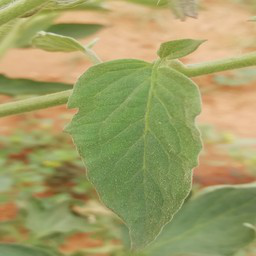

In [5]:
tf.keras.preprocessing.image.load_img(r"C:\Users\younu\Desktop\My Py Scripts\Git Repos\17_Tomato Leaf Deficiency\tomato_leaf_images\train\Healthy\IMG_20190630_111435_256.jpg")

In [6]:
training_data = Path(r"C:\Users\younu\Desktop\My Py Scripts\Git Repos\17_Tomato Leaf Deficiency\tomato_leaf_images\train")
validation_data = Path(r"C:\Users\younu\Desktop\My Py Scripts\Git Repos\17_Tomato Leaf Deficiency\tomato_leaf_images\val")

In [7]:
# Create a dictionary to map the labels to integer

labels_dict = {"AmericanLeafMiner" : 0, "Healthy" : 1,
               "MagnesiumDeficiency" : 2, 
               "SerpentineLeafMiner" : 3}

In [8]:
# Creating a DF for training dataset

train_df = []

for folder in os.listdir(training_data):
    imgs_path = training_data / folder
    imgs = sorted(imgs_path.glob('*.jpg'))
    
    for img_name in imgs:
        train_df.append((str(img_name), labels_dict[folder]))
        
train_df = pd.DataFrame(train_df, columns = ['image', 'label'],
                       index = None)
train_df = train_df.sample(frac = 1, ).reset_index(drop = True)

# Creating validation DF
val_df = []

for folder in os.listdir(validation_data):
    imgs_path = validation_data / folder
    imgs = sorted(imgs_path.glob('*.jpg'))
    
    for img_name in imgs:
        val_df.append((str(img_name), labels_dict[folder]))
        
val_df = pd.DataFrame(val_df, columns = ['image', 'label'],
                       index = None)
val_df = val_df.sample(frac = 1, ).reset_index(drop = True)

# How many samples do we have in our training and validation data
print("# of traning samples : ", len(train_df))
print(train_df.head())
print()
print("# of validation samples : ", len(val_df))
print(val_df.head())

# of traning samples :  4356
                                               image  label
0  C:\Users\younu\Desktop\My Py Scripts\Git Repos...      1
1  C:\Users\younu\Desktop\My Py Scripts\Git Repos...      2
2  C:\Users\younu\Desktop\My Py Scripts\Git Repos...      1
3  C:\Users\younu\Desktop\My Py Scripts\Git Repos...      3
4  C:\Users\younu\Desktop\My Py Scripts\Git Repos...      2

# of validation samples :  486
                                               image  label
0  C:\Users\younu\Desktop\My Py Scripts\Git Repos...      0
1  C:\Users\younu\Desktop\My Py Scripts\Git Repos...      3
2  C:\Users\younu\Desktop\My Py Scripts\Git Repos...      0
3  C:\Users\younu\Desktop\My Py Scripts\Git Repos...      0
4  C:\Users\younu\Desktop\My Py Scripts\Git Repos...      0


In [9]:
# Resiging all images to same size

img_rows, img_cols, img_channels = 224, 224, 3
batch_size = 8
nb_classes = 4

In [10]:
# Data Augmentation

seed = 1234
ia.seed(seed)

seq = iaa.OneOf([iaa.Fliplr(), iaa.Affine(rotate = 20),
                iaa.Multiply((1.2, 1.5))])

In [11]:
# # Data Generators

# def data_generator(data, batch_size, preprocessing_function = None, is_validation_data = False):
#     n = len(data)
#     nb_batches = int(np.ceil(n / batch_size))
#     indices = np.arange(n)
    
#     while True:
#         if not is_validation_data:
#             np.random.shuffle(indices)
            
#         for i in range(nb_batches):
#             next_batch_indices  = indices[i * batch_size : (i + 1) * batch_size]
#             nb_examples = len(next_batch_indices)
            
# #         batch_data = np.zeroes(nb_examples, img_rows, img_cols, img_channels,
# #                               dtypes = np.float64)
# #         batch_labels = np.zeros(nb_examples, nb_classes, dtypes = np.float64)
        
#         batch_data = np.zeros((nb_examples, img_rows, img_cols, img_channels), dtype=np.float32)
#         batch_labels = np.zeros((nb_examples, nb_classes), dtype=np.float32)
        
#         # Process the next batch
        
#         for j, idx in enumerate(next_batch_indices):
#             img = cv2.imread(data.iloc[idx]['image'])
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             label = data.iloc[idx]['label']
            
#             if not is_validation_data:
#                 img = seq.augment_image(img)
                
#             img = cv2.reize(img, (img_rows, img_cols)).astype(np.float32)
#             batch_data[j] = img
#             batch_labels[j] = to_categorical(label, num_classes = nb_classes)
            
#             if preprocessing_function is not None:
#                 batch_data = preprocessing_function(batch_data)
            
#             yield batch_data, batch_labels

# Correcting the data_generator function

def data_generator(data, batch_size, preprocessing_function=None, is_validation_data=False):
    n = len(data)
    nb_batches = int(np.ceil(n / batch_size))
    indices = np.arange(n)

    while True:
        if not is_validation_data:
            np.random.shuffle(indices)

        for i in range(nb_batches):
            next_batch_indices = indices[i * batch_size: (i + 1) * batch_size]
            nb_examples = len(next_batch_indices)

            batch_data = np.zeros((nb_examples, img_rows, img_cols, img_channels), dtype=np.float32)
            batch_labels = np.zeros((nb_examples, nb_classes), dtype=np.float32)

            # Process the next batch
            for j, idx in enumerate(next_batch_indices):
                img = cv2.imread(data.iloc[idx]['image'])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                label = data.iloc[idx]['label']

                if not is_validation_data:
                    img = seq.augment_image(img)

                img = cv2.resize(img, (img_rows, img_cols)).astype(np.float32)
                batch_data[j] = img
                batch_labels[j] = to_categorical(label, num_classes=nb_classes)

            if preprocessing_function is not None:
                batch_data = preprocessing_function(batch_data)

            yield batch_data, batch_labels

# preprocessing_fn = vgg16.preprocess_input

# train_data_gen = data_generator(train_df, batch_size, preprocessing_fn)
# val_data_gen = data_generator(val_df, batch_size, preprocessing_fn, is_validation_data=True)


In [12]:
preprocessing_fn = vgg16.preprocess_input

train_data_gen = data_generator(train_df, batch_size, preprocessing_fn)
val_data_gen = data_generator(val_df, batch_size, preprocessing_fn, is_validation_data = True)

In [13]:
# Model definition
# Fine tuning model
# No leaf in imagenet

def get_base_model():
    base_model = vgg16.VGG16(input_shape = (img_rows, img_cols, img_channels),
                            weights = 'imagenet', include_top = True)
    return base_model

In [14]:
base_model = get_base_model()
base_model_output = base_model.layers[-2].output
# -2 to get the second last using negative indexing
# Since fine tuning we freeze the first 4 blocks

x = L.Dropout(0.5, name = 'drop2')(base_model_output)
output = L.Dense(nb_classes, activation = 'softmax', name = 'func3')(x)

model = Model(base_model.input, output)

In [15]:
# Free all he base model layers except DNN

for layer in base_model.layers[:-1]:
    layer.trainable = False
    
# Compile and fit the model    
optimizer = RMSprop(0.001)
model.compile(loss = 'categorical_crossentropy',
             optimizer = optimizer, metrics = ['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ func3 (Dense)                   │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,276,932 (512.23 MB)

 Trainable params: 16,388 (64.02 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [16]:
# Model Training

es = EarlyStopping(patience = 100, restore_best_weights = True)

chckpnt = ModelCheckpoint(filepath = "model_checkpoint.keras", save_best_only = True)

nb_train_steps = int(np.ceil(len(train_df) / batch_size))
nb_val_steps = int(np.ceil(len(val_df) / batch_size))

nb_epochs = 50

In [17]:
history = model.fit(train_data_gen, epochs = nb_epochs,
                    steps_per_epoch = nb_train_steps,
                    validation_data = val_data_gen,
                    validation_steps = nb_val_steps, 
                   callbacks = [es, chckpnt])

C:\Users\younu\anaconda3\Lib\site-packages\imgaug\augmenters\meta.py:3368: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  augmenter_active = np.zeros((nb_rows, len(self)), dtype=np.bool)


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
base_model = VGG16(include_top = True, weights = "imagenet", 
                   input_shape = (224, 224, 3))

In [ ]:
base_model.trainable = True
# base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
        
    if set_trainable:
        layer_trainable = True
        
    else:
        layer_trainable = False
        
for layer in base_model.layers:
    print(layer.name, layer.trainable)

In [18]:
# Chat GPT code

import cv2  # Computer image
import imgaug as ia
import matplotlib.pyplot as plt
import numpy as np
import os, glob  # Read the path file correctly
import pandas as pd
import tensorflow as tf
import zipfile

from imgaug import augmenters as iaa
from pathlib import Path
from skimage.io import imread, imsave
from skimage.transform import resize
from tensorflow import keras
from keras.models import Model
from keras import layers as L
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import RMSprop
from keras.applications import vgg16
from keras.applications.vgg16 import VGG16

%matplotlib inline

path = r"C:\Users\younu\Desktop\My Py Scripts\Git Repos\17_Tomato Leaf Deficiency\tomato_leaf_images.zip"

zip_obect = zipfile.ZipFile(file=path, mode='r')
zip_obect.extractall('./')
zip_obect.close()

tf.keras.preprocessing.image.load_img(
    r"C:\Users\younu\Desktop\My Py Scripts\Git Repos\17_Tomato Leaf Deficiency\tomato_leaf_images\train\Healthy\IMG_20190630_111435_256.jpg")

training_data = Path(
    r"C:\Users\younu\Desktop\My Py Scripts\Git Repos\17_Tomato Leaf Deficiency\tomato_leaf_images\train")
validation_data = Path(
    r"C:\Users\younu\Desktop\My Py Scripts\Git Repos\17_Tomato Leaf Deficiency\tomato_leaf_images\val")

# Create a dictionary to map the labels to integer

labels_dict = {"AmericanLeafMiner": 0, "Healthy": 1,
               "MagnesiumDeficiency": 2,
               "SerpentineLeafMiner": 3}

# Creating a DF for training dataset

train_df = []

for folder in os.listdir(training_data):
    imgs_path = training_data / folder
    imgs = sorted(imgs_path.glob('*.jpg'))

    for img_name in imgs:
        train_df.append((str(img_name), labels_dict[folder]))

train_df = pd.DataFrame(train_df, columns=['image', 'label'],
                        index=None)
train_df = train_df.sample(frac=1).reset_index(drop=True)

# Creating validation DF
val_df = []

for folder in os.listdir(validation_data):
    imgs_path = validation_data / folder
    imgs = sorted(imgs_path.glob('*.jpg'))

    for img_name in imgs:
        val_df.append((str(img_name), labels_dict[folder]))

val_df = pd.DataFrame(val_df, columns=['image', 'label'],
                      index=None)
val_df = val_df.sample(frac=1).reset_index(drop=True)

# How many samples do we have in our training and validation data
print("# of training samples: ", len(train_df))
print(train_df.head())
print()
print("# of validation samples: ", len(val_df))
print(val_df.head())

# Resizing all images to the same size

img_rows, img_cols, img_channels = 224, 224, 3
batch_size = 8
nb_classes = 4

# Data Augmentation

seed = 1234
ia.seed(seed)

seq = iaa.OneOf([iaa.Fliplr(), iaa.Affine(rotate=20),
                 iaa.Multiply((1.2, 1.5))])

# Data Generators

def data_generator(data, batch_size, preprocessing_function=None, is_validation_data=False):
    n = len(data)
    nb_batches = int(np.ceil(n / batch_size))
    indices = np.arange(n)

    while True:
        if not is_validation_data:
            np.random.shuffle(indices)

        for i in range(nb_batches):
            next_batch_indices = indices[i * batch_size: (i + 1) * batch_size]
            nb_examples = len(next_batch_indices)

            batch_data = np.zeros((nb_examples, img_rows, img_cols, img_channels), dtype=np.float32)
            batch_labels = np.zeros((nb_examples, nb_classes), dtype=np.float32)

            # Process the next batch
            for j, idx in enumerate(next_batch_indices):
                img = cv2.imread(data.iloc[idx]['image'])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                label = data.iloc[idx]['label']

                if not is_validation_data:
                    img = seq.augment_image(img)

                img = cv2.resize(img, (img_rows, img_cols)).astype(np.float32)
                batch_data[j] = img
                batch_labels[j] = to_categorical(label, num_classes=nb_classes)

            if preprocessing_function is not None:
                batch_data = preprocessing_function(batch_data)

            yield batch_data, batch_labels

preprocessing_fn = vgg16.preprocess_input

train_data_gen = data_generator(train_df, batch_size, preprocessing_fn)
val_data_gen = data_generator(val_df, batch_size, preprocessing_fn, is_validation_data=True)

# Model definition
# Fine tuning model
# No leaf in ImageNet

def get_base_model():
    base_model = vgg16.VGG16(input_shape=(img_rows, img_cols, img_channels),
                             weights='imagenet', include_top=True)
    return base_model

base_model = get_base_model()
base_model_output = base_model.layers[-2].output
# -2 to get the second last using negative indexing
# Since fine tuning we freeze the first 4 blocks

x = L.Dropout(0.5, name='drop2')(base_model_output)
output = L.Dense(nb_classes, activation='softmax', name='func3')(x)

model = Model(base_model.input, output)

# Freeze all the base model layers except DNN

for layer in base_model.layers[:-1]:
    layer.trainable = False

# Compile and fit the model
optimizer = RMSprop(0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])
model.summary()

# Model Training

es = EarlyStopping(patience=100, restore_best_weights=True)
chckpnt = ModelCheckpoint(filepath="model_checkpoint.keras", save_best_only=True)

nb_train_steps = int(np.ceil(len(train_df) / batch_size))
nb_val_steps = int(np.ceil(len(val_df) / batch_size))
nb_epochs = 50

history = model.fit(train_data_gen, 
                    epochs=nb_epochs,
                    steps_per_epoch=nb_train_steps,
                    validation_data=val_data_gen,
                    validation_steps=nb_val_steps,
                    callbacks=[es, chckpnt])


# of training samples:  4356
                                               image  label
0  C:\Users\younu\Desktop\My Py Scripts\Git Repos...      0
1  C:\Users\younu\Desktop\My Py Scripts\Git Repos...      1
2  C:\Users\younu\Desktop\My Py Scripts\Git Repos...      0
3  C:\Users\younu\Desktop\My Py Scripts\Git Repos...      0
4  C:\Users\younu\Desktop\My Py Scripts\Git Repos...      0

# of validation samples:  486
                                               image  label
0  C:\Users\younu\Desktop\My Py Scripts\Git Repos...      3
1  C:\Users\younu\Desktop\My Py Scripts\Git Repos...      2
2  C:\Users\younu\Desktop\My Py Scripts\Git Repos...      0
3  C:\Users\younu\Desktop\My Py Scripts\Git Repos...      1
4  C:\Users\younu\Desktop\My Py Scripts\Git Repos...      0


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ func3 (Dense)                   │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,276,932 (512.23 MB)

 Trainable params: 16,388 (64.02 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

C:\Users\younu\anaconda3\Lib\site-packages\imgaug\augmenters\meta.py:3368: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  augmenter_active = np.zeros((nb_rows, len(self)), dtype=np.bool)


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations